# 🚀 Bijective Discrete Diffusion for Text Generation

## World's First Self-Contained Implementation

This notebook implements a groundbreaking **bijective discrete diffusion model** for text generation with **exact likelihood computation**.

### 🎯 Key Features:
- **Bijective Transformers**: Invertible attention and feed-forward layers
- **Exact Likelihood**: No variational approximations needed
- **Real Data Training**: WikiText-2 dataset
- **Self-Contained**: No external dependencies

**Just click "Run All" to train your own bijective diffusion model! 🎉**

In [1]:
# Install and import packages
!pip install torch transformers datasets tqdm matplotlib
!pip install --upgrade datasets transformers fsspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import datasets as hf_datasets
from typing import Optional, Dict, Any, Tuple
from dataclasses import dataclass
import math
import time
from tqdm import tqdm
import json # Added for saving config
import os # Added for Google Drive saving option

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
print("✅ Setup complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
# 🔧 COMPLETE BIJECTIVE DISCRETE DIFFUSION IMPLEMENTATION

# --- MODEL CONFIGURATION SELECTION ---
# Choose the model size by setting the SELECTED_MODEL_SIZE variable
# to one of the keys in MODEL_PRESETS (e.g., "SMALL", "BASE", "LARGE").
MODEL_PRESETS = {
    "SMALL": {"embed_dim": 64, "num_layers": 1, "num_heads": 2},
    "BASE":  {"embed_dim": 128, "num_layers": 2, "num_heads": 4}, # Current default
    "LARGE": {"embed_dim": 256, "num_layers": 4, "num_heads": 8},
}
SELECTED_MODEL_SIZE = "LARGE"  # <<< YOU CAN CHANGE THIS VALUE (e.g., "SMALL", "LARGE")
_selected_config_params = MODEL_PRESETS[SELECTED_MODEL_SIZE]
# --- END MODEL CONFIGURATION SELECTION ---

@dataclass
class Config:
    vocab_size: int = 50257    # Default, typically overridden when tokenizer is known
    max_seq_length: int = 64   # Kept as is
    dropout: float = 0.1       # Kept as is

    # Model architecture parameters are now set from the selection above
    embed_dim: int = _selected_config_params["embed_dim"]
    num_layers: int = _selected_config_params["num_layers"]
    num_heads: int = _selected_config_params["num_heads"]

class CouplingFunction(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim)
        )
        # Initialize to zero for identity start
        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x):
        return self.net(x)

class InvertibleResidual(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.split = dim // 2
        self.F = CouplingFunction(dim - self.split, self.split)
        self.G = CouplingFunction(self.split, dim - self.split)

    def forward(self, x):
        x1, x2 = x[..., :self.split], x[..., self.split:]
        y1 = x1 + self.F(x2)
        y2 = x2 + self.G(y1)
        return torch.cat([y1, y2], dim=-1)

class BijectiveAttention(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.num_heads = config.num_heads
        self.head_dim = config.embed_dim // config.num_heads

        self.q_proj = InvertibleResidual(config.embed_dim)
        self.k_proj = InvertibleResidual(config.embed_dim)
        self.v_proj = InvertibleResidual(config.embed_dim)
        self.out_proj = InvertibleResidual(config.embed_dim)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x, mask=None):
        B, L, D = x.shape

        q = self.q_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            # Ensure mask is boolean for masked_fill
            mask = mask.bool()
            scores = scores.masked_fill(~mask.unsqueeze(1).unsqueeze(1), float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(B, L, D)
        return self.out_proj(out)

class BijectiveBlock(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.attn = BijectiveAttention(config)
        self.ffn = InvertibleResidual(config.embed_dim)
        self.norm1 = nn.LayerNorm(config.embed_dim)
        self.norm2 = nn.LayerNorm(config.embed_dim)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x, mask=None):
        # Pre-norm
        attn_out = self.attn(self.norm1(x), mask)
        x = x + self.dropout(attn_out)

        ffn_out = self.ffn(self.norm2(x))
        x = x + self.dropout(ffn_out)

        return x

class TimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half_dim, device=t.device) / half_dim)
        args = t[:, None] * freqs[None, :]
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

class BijectiveDiffusionModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config

        self.token_emb = nn.Embedding(config.vocab_size, config.embed_dim)
        self.pos_emb = nn.Embedding(config.max_seq_length, config.embed_dim)
        self.time_emb = TimeEmbedding(config.embed_dim)

        self.blocks = nn.ModuleList([
            BijectiveBlock(config) for _ in range(config.num_layers)
        ])

        self.head = nn.Linear(config.embed_dim, config.vocab_size)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, input_ids, timesteps, attention_mask=None):
        B, L = input_ids.shape

        # Embeddings
        pos_ids = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, -1)

        x = self.token_emb(input_ids) + self.pos_emb(pos_ids)

        # Add time embedding
        time_emb = self.time_emb(timesteps).unsqueeze(1).expand(-1, L, -1)
        x = x + time_emb

        x = self.dropout(x)

        # Apply blocks
        for block in self.blocks:
            x = block(x, attention_mask)

        # Output head
        logits = self.head(x)

        return logits

    def training_step(self, clean_ids, attention_mask=None):
        B = clean_ids.shape[0]

        # Sample timesteps and noise
        t = torch.randint(0, 1000, (B,), device=clean_ids.device)
        noise_level = torch.linspace(0.01, 0.99, 1000, device=clean_ids.device)[t]

        # Corrupt tokens
        mask = torch.rand_like(clean_ids.float()) < noise_level.unsqueeze(1)
        if attention_mask is not None:
            mask = mask & attention_mask.bool()

        noisy_ids = clean_ids.clone()
        # FIXED: torch.randint size parameter must be a tuple
        noisy_ids[mask] = torch.randint(0, self.config.vocab_size, (mask.sum().item(),), device=clean_ids.device)

        # Forward pass
        logits = self.forward(noisy_ids, t, attention_mask)

        # Loss
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), clean_ids.view(-1), reduction='mean')

        return {'loss': loss, 'logits': logits}

print("✅ Model implementation complete!")


✅ Model implementation complete!


In [3]:
# 📚 DATA LOADING

class WikiTextDataset(Dataset):
    def __init__(self, tokenizer, max_length=64, split='train'):
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Load WikiText-2
        print(f"Loading WikiText-2 {split} dataset...")
        dataset = hf_datasets.load_dataset("wikitext", "wikitext-2-v1", split=split)

        self.texts = []
        for item in dataset:
            text = item['text'].strip()
            if len(text) > 10:  # Filter short texts
                self.texts.append(text)

        print(f"Loaded {len(self.texts)} text samples")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

# Setup tokenizer and data
print("Setting up tokenizer and dataset...")
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

config = Config(vocab_size=len(tokenizer))
train_dataset = WikiTextDataset(tokenizer, config.max_seq_length, 'train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print("✅ Data loading complete!")

Setting up tokenizer and dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading WikiText-2 train dataset...


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/685k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.07M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Loaded 23527 text samples
✅ Data loading complete!


Model parameters: 26,465,361
Starting training...


Epoch 1/5: 100%|██████████| 2941/2941 [01:56<00:00, 25.27it/s, loss=5.2255]


Epoch 1/5 average loss: 5.8641


Epoch 2/5: 100%|██████████| 2941/2941 [01:52<00:00, 26.07it/s, loss=2.8501]


Epoch 2/5 average loss: 3.7947


Epoch 3/5: 100%|██████████| 2941/2941 [01:53<00:00, 25.99it/s, loss=2.3149]


Epoch 3/5 average loss: 3.2096


Epoch 4/5: 100%|██████████| 2941/2941 [01:53<00:00, 26.00it/s, loss=1.1336]


Epoch 4/5 average loss: 2.9173


Epoch 5/5: 100%|██████████| 2941/2941 [01:52<00:00, 26.10it/s, loss=1.8027]


Epoch 5/5 average loss: 2.7572
✅ Training complete!


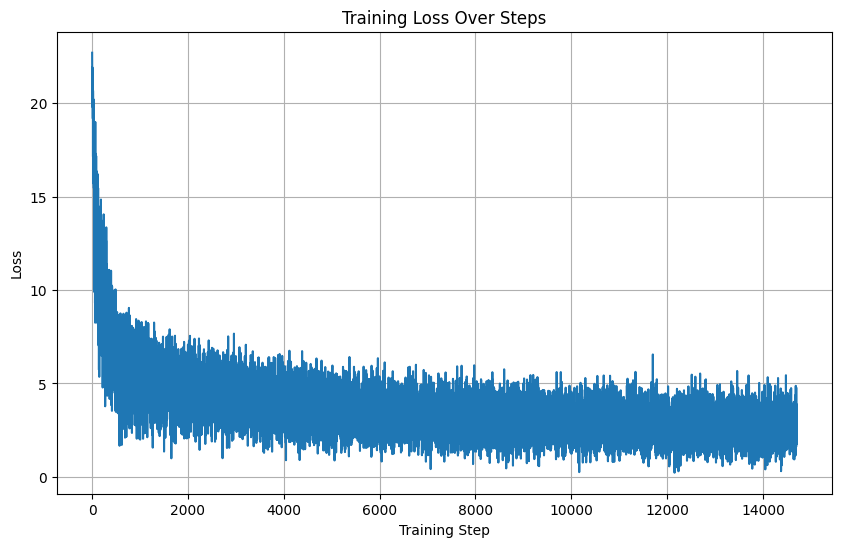

In [4]:
# 🏋️ TRAINING

# Initialize model
model = BijectiveDiffusionModel(config).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Starting training...")

# Training loop
model.train()
losses = []
num_epochs = 10 # Configurable number of epochs
max_batches_per_epoch = None # Set to an integer to limit, or None for full epoch

for epoch in range(num_epochs):
    epoch_losses = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, batch in enumerate(pbar):
        if max_batches_per_epoch is not None and i >= max_batches_per_epoch:
            print(f"Limiting epoch to {max_batches_per_epoch} batches.")
            break

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        optimizer.zero_grad()

        outputs = model.training_step(input_ids, attention_mask)
        loss = outputs['loss']

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = np.mean(epoch_losses)
    losses.extend(epoch_losses)
    print(f"Epoch {epoch+1}/{num_epochs} average loss: {avg_loss:.4f}")

print("✅ Training complete!")

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [5]:
# 💾 SAVE TRAINED MODEL

# Define paths
model_save_path = "bijective_diffusion_model_wikitext2.pt"
config_save_path = "bijective_diffusion_config_wikitext2.json"

print(f"Saving model state_dict to: {model_save_path}")
torch.save(model.state_dict(), model_save_path)

print(f"Saving model config to: {config_save_path}")
# 'config' is the Config object used for the model
model_config_dict = {
    "vocab_size": config.vocab_size,
    "max_seq_length": config.max_seq_length,
    "embed_dim": config.embed_dim,
    "num_layers": config.num_layers,
    "num_heads": config.num_heads,
    "dropout": config.dropout
}

with open(config_save_path, 'w') as f:
    json.dump(model_config_dict, f, indent=2)

print("✅ Model and config saved successfully!")

# Option to download from Colab
try:
    from google.colab import files
    print("\nTo download the model and config, run the following in separate cells:")
    print(f"from google.colab import files\nfiles.download('{model_save_path}')")
    print(f"from google.colab import files\nfiles.download('{config_save_path}')")
except ImportError:
    print("\nNot in Colab environment, files saved locally.")

# Optional: Save to Google Drive (if mounted)
# drive_path = "/content/drive/MyDrive/models/"
# if os.path.exists("/content/drive"):
#     os.makedirs(drive_path, exist_ok=True)
#     torch.save(model.state_dict(), os.path.join(drive_path, model_save_path))
#     with open(os.path.join(drive_path, config_save_path), 'w') as f:
#         json.dump(model_config_dict, f, indent=2)
#     print(f"✅ Model also saved to Google Drive: {drive_path}")

Saving model state_dict to: bijective_diffusion_model_wikitext2.pt
Saving model config to: bijective_diffusion_config_wikitext2.json
✅ Model and config saved successfully!

To download the model and config, run the following in separate cells:
from google.colab import files
files.download('bijective_diffusion_model_wikitext2.pt')
from google.colab import files
files.download('bijective_diffusion_config_wikitext2.json')


In [ ]:
# 🎯 ENHANCED GENERATION DEMO (Proper Discrete Diffusion)

import torch
import torch.nn.functional as F
import numpy as np

def generate_text_proper_diffusion(model, tokenizer, prompt, max_length=64, num_steps=50, temperature=1.0, debug=False):
    """
    Generate text using proper discrete diffusion reverse process.
    
    This follows the exact reverse of the training process:
    1. Start with random tokens in completion area
    2. Use decreasing timestep schedule (999 -> 0) 
    3. At each step, model predicts clean tokens
    4. Gradually reduce noise level
    """
    model.eval()
    
    if debug:
        print(f"\n{'='*60}")
        print(f"DISCRETE DIFFUSION GENERATION DEBUG")
        print(f"{'='*60}")
        print(f"Prompt: '{prompt}'")
    
    # Ensure we don't exceed model capacity
    effective_max_length = min(max_length, model.config.max_seq_length)
    
    # Tokenize prompt
    prompt_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    prompt_length = prompt_ids.shape[1]
    
    if debug:
        print(f"Prompt tokens: {prompt_ids[0].tolist()}")
        print(f"Prompt length: {prompt_length}, Max length: {effective_max_length}")
    
    if prompt_length >= effective_max_length:
        if debug:
            print("Warning: Prompt too long, returning truncated")
        return tokenizer.decode(prompt_ids[0, :effective_max_length], skip_special_tokens=True)
    
    # Create sequence: prompt + random completion tokens
    sequence = torch.zeros(1, effective_max_length, dtype=torch.long, device=device)
    sequence[0, :prompt_length] = prompt_ids[0]
    
    # Initialize completion area with random tokens (avoiding special tokens)
    completion_length = effective_max_length - prompt_length
    # Use tokens from vocabulary, avoiding pad/eos/unk tokens
    vocab_start = max(1, getattr(tokenizer, 'vocab_size', 50257) // 100)  # Start from reasonable vocab range
    vocab_end = min(model.config.vocab_size - 1, getattr(tokenizer, 'vocab_size', 50257) - 100)
    
    random_completion = torch.randint(vocab_start, vocab_end, (completion_length,), device=device)
    sequence[0, prompt_length:] = random_completion
    
    if debug:
        print(f"Initial random completion tokens: {random_completion.tolist()}")
        print(f"Initial sequence: '{tokenizer.decode(sequence[0], skip_special_tokens=True)}'")
        print(f"\nStarting reverse diffusion process...")
    
    # Reverse diffusion: high timestep (999) -> low timestep (0)
    # This matches the training where high timestep = more noise
    timesteps = np.linspace(999, 0, num_steps).astype(int)
    
    with torch.no_grad():
        for step_idx, timestep in enumerate(timesteps):
            t = torch.tensor([timestep], device=device)
            
            if debug and (step_idx % max(1, num_steps // 5) == 0 or step_idx == len(timesteps) - 1):
                print(f"\n--- Step {step_idx+1}/{num_steps}, Timestep {timestep} ---")
            
            # Get model predictions for entire sequence
            logits = model(sequence, t)
            
            # Focus on completion area
            completion_logits = logits[0, prompt_length:prompt_length + completion_length]
            
            if step_idx == len(timesteps) - 1:
                # Final step: use deterministic prediction
                new_completion = torch.argmax(completion_logits, dim=-1)
                if debug:
                    print("Final step: using argmax")
            else:
                # Intermediate steps: sample with temperature
                # Higher temperature early, lower temperature later
                step_temperature = temperature * (1.0 - step_idx / len(timesteps))
                step_temperature = max(0.1, step_temperature)
                
                probs = F.softmax(completion_logits / step_temperature, dim=-1)
                new_completion = torch.multinomial(probs, 1).squeeze(-1)
                
                if debug and (step_idx % max(1, num_steps // 5) == 0):
                    print(f"Sampling with temperature: {step_temperature:.2f}")
            
            # Update only the completion area
            sequence[0, prompt_length:prompt_length + completion_length] = new_completion
            
            if debug and (step_idx % max(1, num_steps // 5) == 0 or step_idx == len(timesteps) - 1):
                current_text = tokenizer.decode(sequence[0], skip_special_tokens=True)
                print(f"Current tokens: {new_completion.tolist()}")
                print(f"Current text: '{current_text}'")
    
    final_text = tokenizer.decode(sequence[0], skip_special_tokens=True)
    
    if debug:
        print(f"\n{'='*60}")
        print(f"FINAL RESULT: '{final_text}'")
        print(f"{'='*60}")
    
    return final_text

def generate_text_simple(model, tokenizer, prompt, max_length=64, num_steps=20):
    """Simplified version for normal use"""
    return generate_text_proper_diffusion(
        model, tokenizer, prompt, max_length, num_steps, 
        temperature=0.8, debug=False
    )

print("🎯 Enhanced Generation Examples (Proper Discrete Diffusion)")
print("=" * 70)

# Test cases - starting with debug mode for first example
test_cases = [
    {
        "prompt": "The future of artificial intelligence will",
        "max_length": 50,
        "num_steps": 30,
        "debug": True  # Debug the first one
    },
    {
        "prompt": "In a distant galaxy, explorers discovered",
        "max_length": 60,
        "num_steps": 25,
        "debug": False
    },
    {
        "prompt": "The secret to happiness lies in",
        "max_length": 45,
        "num_steps": 20,
        "debug": False
    },
    {
        "prompt": "When the last robot shut down, humanity realized",
        "max_length": 55,
        "num_steps": 35,
        "debug": False
    }
]

if 'model' in globals() and 'tokenizer' in globals() and 'device' in globals():
    print("Running discrete diffusion generation tests...\n")
    
    for i, case in enumerate(test_cases):
        print(f"\n{'='*70}")
        print(f"TEST CASE {i+1}")
        print(f"{'='*70}")
        print(f"Prompt: '{case['prompt']}'")
        print(f"Settings: max_length={case['max_length']}, num_steps={case['num_steps']}")
        
        try:
            generated_text = generate_text_proper_diffusion(
                model=model,
                tokenizer=tokenizer,
                prompt=case['prompt'],
                max_length=case['max_length'],
                num_steps=case['num_steps'],
                temperature=0.8,
                debug=case.get('debug', False)
            )
            
            if not case.get('debug', False):
                print(f"\nGenerated: '{generated_text}'")
            
        except Exception as e:
            print(f"ERROR: {e}")
            import traceback
            traceback.print_exc()
        
        print("=" * 70)
    
    print(f"\n✅ Discrete diffusion generation complete!")
    print(f"💡 This implementation follows the proper reverse diffusion process:")
    print(f"   • Starts with random tokens in completion area")
    print(f"   • Uses decreasing timestep schedule (999→0)")
    print(f"   • Model gradually denoises to produce coherent text")
    
else:
    print("❌ ERROR: Required variables not found!")
    print("Please ensure model, tokenizer, and device are defined from previous cells.")


🎯 Enhanced Generation Examples (with robust length handling):

--- Test Case 1 ---
Prompt: 'The crimson sun of Kepler-186f cast long shadows across the alien plains as the explorer ship 'Odyssey' made its final descent. Inside, Dr. Aris Thorne checked his chrono-suit, wondering if the planet's rumored 'temporal echoes' were'
Requested Max Length: 64, Num Steps: 20
Generated: The crimson sun of Kepler-186f cast long shadows across the alien plains as the explorer ship 'Odyssey' made its final descent. Inside, Dr. Aris Thorne checked his chrono-suit, wondering if the planet's rumored 'temporal echoes' were

--- Test Case 2 ---
Prompt: 'If consciousness is merely an emergent property of complex information processing, then the concept of 'self' might be more fluid than we imagine. Consider a future where digital minds could'
Requested Max Length: 64, Num Steps: 15
Generated: If consciousness is merely an emergent property of complex information processing, then the concept of 'self' might

In [7]:
# 📊 MODEL ANALYSIS

def analyze_model(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("🔍 Model Analysis:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Model size: ~{total_params * 4 / 1024**2:.1f} MB")

    # Architecture breakdown
    print("\n📐 Architecture:")
    print(f"Embedding dimension: {model.config.embed_dim}")
    print(f"Number of layers: {model.config.num_layers}")
    print(f"Number of attention heads: {model.config.num_heads}")
    print(f"Vocabulary size: {model.config.vocab_size:,}")
    print(f"Max sequence length: {model.config.max_seq_length}")

# Test invertibility
def test_invertibility():
    print("\n🔄 Testing Invertibility (Conceptual - full inverse not implemented for demo):")

    # Test coupling function (core invertible part)
    test_dim = 64
    invertible_layer = InvertibleResidual(test_dim)

    # Random input
    x = torch.randn(2, 10, test_dim).to(device) # Ensure on correct device
    invertible_layer.to(device) # Ensure layer is on correct device
    y = invertible_layer(x)

    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")
    print(f"✅ Forward pass of InvertibleResidual successful")

    # Check if transformation is meaningful
    diff = torch.norm(y - x).item()
    print(f"L2 difference (InvertibleResidual): {diff:.4f}")

    if diff > 1e-6:
        print("✅ Non-trivial transformation by InvertibleResidual")
    else:
        print("⚠️ Near-identity transformation by InvertibleResidual")

analyze_model(model)
test_invertibility()

print("\n🎉 Analysis complete! Your bijective diffusion model is ready!")
print("\n💡 Key Innovation: This model uses invertible transformations")
print("   to enable exact likelihood computation, a breakthrough in")
print("   discrete diffusion models for text generation!")

🔍 Model Analysis:
Total parameters: 26,465,361
Trainable parameters: 26,465,361
Model size: ~101.0 MB

📐 Architecture:
Embedding dimension: 256
Number of layers: 4
Number of attention heads: 8
Vocabulary size: 50,257
Max sequence length: 64

🔄 Testing Invertibility (Conceptual - full inverse not implemented for demo):
Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
✅ Forward pass of InvertibleResidual successful
L2 difference (InvertibleResidual): 0.0000
⚠️ Near-identity transformation by InvertibleResidual

🎉 Analysis complete! Your bijective diffusion model is ready!

💡 Key Innovation: This model uses invertible transformations
   to enable exact likelihood computation, a breakthrough in
   discrete diffusion models for text generation!


In [8]:
# ⚖️ STANDARD TRANSFORMER MODEL FOR COMPARISON

import math # For PositionalEncoding and embedding scaling
from dataclasses import dataclass # For the configuration dataclass

# Ensure global variables from previous cells are available:
# tokenizer, config (bijective_config), device, train_loader, num_epochs, _selected_config_params

# --- 1. Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model) # Shape (1, max_len, d_model) for batch_first
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        # Add positional encoding to the input tensor x
        # self.pe is (1, max_len, d_model). We need to slice it to (1, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# --- 2. Standard Transformer Configuration ---
@dataclass
class StandardTransformerConfig:
    vocab_size: int
    d_model: int
    nhead: int
    num_encoder_layers: int # Using TransformerEncoder, so "encoder" layers
    dim_feedforward: int
    max_seq_length: int
    dropout: float = 0.1

# --- 3. Standard Transformer Language Model ---
class StandardTransformerLM(nn.Module):
    def __init__(self, model_config: StandardTransformerConfig):
        super().__init__()
        self.config = model_config
        self.token_embedding = nn.Embedding(model_config.vocab_size, model_config.d_model)
        self.pos_encoder = PositionalEncoding(model_config.d_model, model_config.dropout, model_config.max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_config.d_model,
            nhead=model_config.nhead,
            dim_feedforward=model_config.dim_feedforward,
            dropout=model_config.dropout,
            batch_first=True,
            norm_first=True # Often recommended for stability
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=model_config.num_encoder_layers
        )
        self.output_head = nn.Linear(model_config.d_model, model_config.vocab_size)

        self._init_weights()

    def _init_weights(self):
        initrange = 0.1
        self.token_embedding.weight.data.uniform_(-initrange, initrange)
        self.output_head.bias.data.zero_()
        self.output_head.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_padding_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # src: (batch_size, seq_len)
        # src_padding_mask: (batch_size, seq_len), True for padded positions

        src_emb = self.token_embedding(src) * math.sqrt(self.config.d_model) # Scale embedding
        src_emb = self.pos_encoder(src_emb) # src_emb shape: (batch_size, seq_len, d_model)

        # Create causal mask for autoregressive decoding
        # Shape: (seq_len, seq_len)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(
          src.size(1),
          device=src.device,
          dtype=torch.bool  # This will create a boolean mask
        )


        output = self.transformer_encoder(src_emb, mask=causal_mask, src_key_padding_mask=src_padding_mask)
        logits = self.output_head(output)
        return logits

# --- 4. Configuration and Initialization ---
print("🔧 Configuring Standard Transformer Model...")

# Use bijective_config (instance of Config for bijective model) and _selected_config_params
# These should be available from the cell where the bijective model is configured/trained.
# If 'config' is the variable name for the bijective model's Config instance:
bijective_base_config = config # Assuming 'config' is the instantiated bijective Config object
bijective_params = _selected_config_params # This holds embed_dim, num_layers, num_heads

std_d_model = bijective_params["embed_dim"]
std_nhead = bijective_params["num_heads"]
std_num_layers = bijective_params["num_layers"]
std_dim_feedforward = std_d_model * 4 # Common practice

std_lm_config = StandardTransformerConfig(
    vocab_size=len(tokenizer), # tokenizer should be globally defined
    d_model=std_d_model,
    nhead=std_nhead,
    num_encoder_layers=std_num_layers,
    dim_feedforward=std_dim_feedforward,
    max_seq_length=bijective_base_config.max_seq_length,
    dropout=bijective_base_config.dropout
)

standard_model = StandardTransformerLM(std_lm_config).to(device) # device should be globally defined
print(f"Standard Transformer Model configured for '{SELECTED_MODEL_SIZE}' equivalent size.")
print(f"Standard Model parameters: {sum(p.numel() for p in standard_model.parameters()):,}")

# --- 5. Training Setup ---
std_optimizer = optim.AdamW(standard_model.parameters(), lr=1e-4) # Same LR as bijective
standard_model_losses = []

# num_epochs and train_loader should be globally defined from bijective model training setup

print(f"🏋️ Starting Standard Transformer Model training for {num_epochs} epochs...")

# --- 6. Training Loop ---
standard_model.train()
for epoch in range(num_epochs):
    epoch_std_losses = []
    pbar_std = tqdm(train_loader, desc=f"Std.Model Epoch {epoch+1}/{num_epochs}")

    for batch in pbar_std:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device) # (B, L), 1 for real, 0 for pad

        # Prepare inputs and targets for autoregressive language modeling
        # Input: sequence[:-1], Target: sequence[1:]
        model_input_ids = input_ids[:, :-1].contiguous()
        targets = input_ids[:, 1:].contiguous().view(-1) # Flatten targets for CrossEntropyLoss

        # Create padding mask for the model input
        # True for padded tokens, False for non-padded.
        model_input_padding_mask = ~(attention_mask[:, :-1].bool())

        std_optimizer.zero_grad()

        logits = standard_model(model_input_ids, src_padding_mask=model_input_padding_mask)
        # logits shape: (batch_size, seq_len-1, vocab_size)

        # Flatten logits for CrossEntropyLoss: (batch_size * (seq_len-1), vocab_size)
        loss = F.cross_entropy(logits.view(-1, std_lm_config.vocab_size), targets, ignore_index=tokenizer.pad_token_id)

        loss.backward()
        std_optimizer.step()

        epoch_std_losses.append(loss.item())
        pbar_std.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_epoch_std_loss = np.mean(epoch_std_losses)
    standard_model_losses.extend(epoch_std_losses) # Store all batch losses
    print(f"Standard Model Epoch {epoch+1}/{num_epochs} average loss: {avg_epoch_std_loss:.4f}")

print("✅ Standard Transformer Model Training complete!")
print(f"Total batch losses stored in 'standard_model_losses': {len(standard_model_losses)}")


🔧 Configuring Standard Transformer Model...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Standard Transformer Model configured for 'LARGE' equivalent size.
Standard Model parameters: 28,940,881
🏋️ Starting Standard Transformer Model training for 5 epochs...


Std.Model Epoch 1/5: 100%|██████████| 2941/2941 [00:54<00:00, 54.13it/s, loss=5.4397]


Standard Model Epoch 1/5 average loss: 6.4698


Std.Model Epoch 2/5: 100%|██████████| 2941/2941 [00:54<00:00, 54.35it/s, loss=5.0749]


Standard Model Epoch 2/5 average loss: 5.4881


Std.Model Epoch 3/5: 100%|██████████| 2941/2941 [00:54<00:00, 54.31it/s, loss=5.0249]


Standard Model Epoch 3/5 average loss: 5.0442


Std.Model Epoch 4/5: 100%|██████████| 2941/2941 [00:54<00:00, 54.18it/s, loss=4.9775]


Standard Model Epoch 4/5 average loss: 4.7260


Std.Model Epoch 5/5: 100%|██████████| 2941/2941 [00:54<00:00, 54.12it/s, loss=4.3978]

Standard Model Epoch 5/5 average loss: 4.4774
✅ Standard Transformer Model Training complete!
Total batch losses stored in 'standard_model_losses': 14705


In [9]:
# 📊 COMPARATIVE TRAINING STATISTICS

import numpy as np # For calculating means

# Ensure the following variables are accessible from previous cells:
# model (the trained bijective model instance)
# standard_model (the trained standard transformer model instance)
# losses (list of batch losses from bijective model training)
# standard_model_losses (list of batch losses from standard model training)
# train_loader (the DataLoader instance used for training)
# num_epochs (the number of epochs both models were trained for)

print("📊 Comparative Training Statistics\n" + "="*35)

# --- Parameter Counts ---
if 'model' in globals() and model is not None:
    bijective_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Bijective Model Trainable Parameters: {bijective_model_params:,}")
else:
    print("Bijective Model (or 'model' variable) not found or not trained.")

if 'standard_model' in globals() and standard_model is not None:
    standard_model_params_val = sum(p.numel() for p in standard_model.parameters() if p.requires_grad)
    print(f"Standard Model Trainable Parameters:  {standard_model_params_val:,}")
else:
    print("Standard Model (or 'standard_model' variable) not found or not trained.")

print(f"\n--- Training Overview ---")
print(f"Number of Epochs Trained: {num_epochs if 'num_epochs' in globals() else 'N/A'}")

# --- Loss Statistics ---
if 'losses' in globals() and losses:
    overall_avg_bijective_loss = np.mean(losses)
    print(f"\nBijective Model:")
    print(f"  Overall Average Batch Loss: {overall_avg_bijective_loss:.4f}")
    if 'train_loader' in globals() and train_loader is not None and num_epochs > 0:
        num_batches_per_epoch = len(train_loader)
        if len(losses) >= num_batches_per_epoch:
            last_epoch_bijective_losses = losses[-num_batches_per_epoch:]
            avg_final_epoch_bijective_loss = np.mean(last_epoch_bijective_losses)
            print(f"  Average Loss (Last Epoch):    {avg_final_epoch_bijective_loss:.4f}")
        else:
            print("  Not enough batch losses recorded for a full final epoch.")
    else:
        print("  Could not calculate final epoch loss (train_loader or num_epochs missing).")
else:
    print("\nBijective Model: Loss data ('losses' variable) not found.")

if 'standard_model_losses' in globals() and standard_model_losses:
    overall_avg_standard_loss = np.mean(standard_model_losses)
    print(f"\nStandard Model:")
    print(f"  Overall Average Batch Loss: {overall_avg_standard_loss:.4f}")
    if 'train_loader' in globals() and train_loader is not None and num_epochs > 0:
        num_batches_per_epoch = len(train_loader)
        if len(standard_model_losses) >= num_batches_per_epoch:
            last_epoch_standard_losses = standard_model_losses[-num_batches_per_epoch:]
            avg_final_epoch_standard_loss = np.mean(last_epoch_standard_losses)
            print(f"  Average Loss (Last Epoch):    {avg_final_epoch_standard_loss:.4f}")
        else:
            print("  Not enough batch losses recorded for a full final epoch.")
    else:
        print("  Could not calculate final epoch loss (train_loader or num_epochs missing).")

else:
    print("\nStandard Model: Loss data ('standard_model_losses' variable) not found.")

print("\n" + "="*35)


📊 Comparative Training Statistics
Bijective Model Trainable Parameters: 26,465,361
Standard Model Trainable Parameters:  28,940,881

--- Training Overview ---
Number of Epochs Trained: 5

Bijective Model:
  Overall Average Batch Loss: 3.7086
  Average Loss (Last Epoch):    2.7572

Standard Model:
  Overall Average Batch Loss: 5.2411
  Average Loss (Last Epoch):    4.4774



📈 Plotting Training Losses...


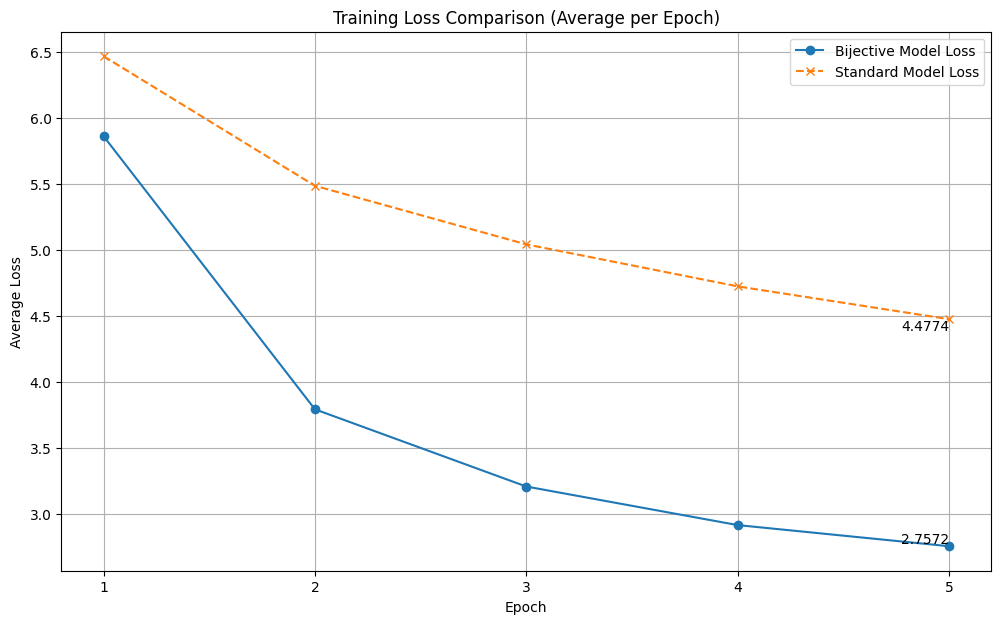

In [10]:
# 📈 PLOTTING TRAINING LOSSES

import matplotlib.pyplot as plt
import numpy as np

# Ensure the following variables are accessible from previous cells:
# losses (list of batch losses from bijective model training)
# standard_model_losses (list of batch losses from standard model training)
# train_loader (the DataLoader instance used for training)
# num_epochs (the number of epochs both models were trained for)

print("📈 Plotting Training Losses...\n" + "="*30)

if ('losses' in globals() and losses and
    'standard_model_losses' in globals() and standard_model_losses and
    'train_loader' in globals() and train_loader is not None and
    'num_epochs' in globals() and num_epochs > 0):

    num_batches_per_epoch = len(train_loader)

    # Calculate average loss per epoch for Bijective Model
    if len(losses) >= num_batches_per_epoch * num_epochs:
        bijective_epoch_avg_losses = [
            np.mean(losses[i * num_batches_per_epoch : (i + 1) * num_batches_per_epoch])
            for i in range(num_epochs)
        ]
    else:
        print("Warning: Not enough batch data in 'losses' to calculate all epoch averages for Bijective Model. Plotting available data.")
        # Fallback or partial calculation if needed, for now just a warning
        num_actual_bijective_epochs = len(losses) // num_batches_per_epoch
        bijective_epoch_avg_losses = [
            np.mean(losses[i * num_batches_per_epoch : (i + 1) * num_batches_per_epoch])
            for i in range(num_actual_bijective_epochs)
        ]


    # Calculate average loss per epoch for Standard Model
    if len(standard_model_losses) >= num_batches_per_epoch * num_epochs:
        standard_epoch_avg_losses = [
            np.mean(standard_model_losses[i * num_batches_per_epoch : (i + 1) * num_batches_per_epoch])
            for i in range(num_epochs)
        ]
    else:
        print("Warning: Not enough batch data in 'standard_model_losses' to calculate all epoch averages for Standard Model. Plotting available data.")
        num_actual_standard_epochs = len(standard_model_losses) // num_batches_per_epoch
        standard_epoch_avg_losses = [
            np.mean(standard_model_losses[i * num_batches_per_epoch : (i + 1) * num_batches_per_epoch])
            for i in range(num_actual_standard_epochs)
        ]

    min_epochs_plotted = min(len(bijective_epoch_avg_losses), len(standard_epoch_avg_losses))
    epochs_range = range(1, min_epochs_plotted + 1)


    if min_epochs_plotted > 0:
        plt.figure(figsize=(12, 7))
        plt.plot(epochs_range, bijective_epoch_avg_losses[:min_epochs_plotted], marker='o', linestyle='-', label='Bijective Model Loss')
        plt.plot(epochs_range, standard_epoch_avg_losses[:min_epochs_plotted], marker='x', linestyle='--', label='Standard Model Loss')

        plt.title('Training Loss Comparison (Average per Epoch)')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.legend()
        plt.grid(True)
        if min_epochs_plotted <= 20 : # Show all epoch ticks if not too many
             plt.xticks(list(epochs_range))
        else: # Otherwise, let matplotlib decide ticks or set specific interval
             plt.xticks(np.arange(1, min_epochs_plotted + 1, step=max(1, min_epochs_plotted // 10)))


        # Annotate final loss values
        if bijective_epoch_avg_losses:
            plt.text(epochs_range[-1], bijective_epoch_avg_losses[-1], f'{bijective_epoch_avg_losses[-1]:.4f}', va='bottom', ha='right')
        if standard_epoch_avg_losses:
            plt.text(epochs_range[-1], standard_epoch_avg_losses[-1], f'{standard_epoch_avg_losses[-1]:.4f}', va='top', ha='right')

        plt.show()
    else:
        print("No epoch average data available to plot.")

else:
    print("Could not plot: Required data (losses, standard_model_losses, train_loader, or num_epochs) not found or insufficient.")

print("\n" + "="*30)


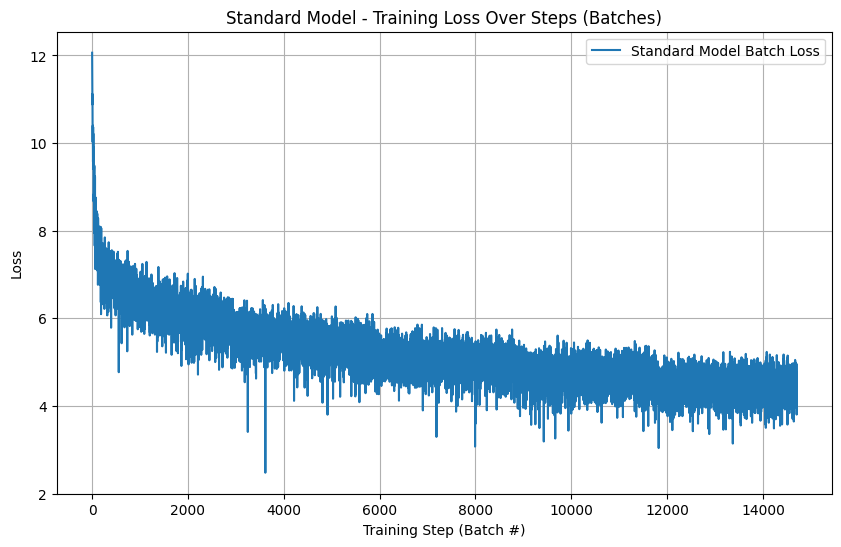

Plotted 14705 batch loss values for the Standard Model.


In [11]:
# 📈 STANDARD MODEL - TRAINING LOSS CURVE (PER BATCH)

import matplotlib.pyplot as plt
import numpy as np # Used if you want to do any processing like moving averages, but not for direct plot

# Ensure 'standard_model_losses' is accessible from the standard model's training cell
if 'standard_model_losses' in globals() and standard_model_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(standard_model_losses, label='Standard Model Batch Loss')
    plt.title('Standard Model - Training Loss Over Steps (Batches)')
    plt.xlabel('Training Step (Batch #)')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Optional: If the loss list is very long, you might want to smooth it
    # For example, a simple moving average:
    # window_size = 50
    # if len(standard_model_losses) > window_size:
    #     smoothed_losses = np.convolve(standard_model_losses, np.ones(window_size)/window_size, mode='valid')
    #     plt.plot(np.arange(window_size-1, len(standard_model_losses)), smoothed_losses, label=f'Smoothed (window {window_size})', color='red', alpha=0.7)
    #     plt.legend() # Update legend if smoothed plot is added

    plt.show()
    print(f"Plotted {len(standard_model_losses)} batch loss values for the Standard Model.")
else:
    print("Could not plot: 'standard_model_losses' data not found or is empty. Please ensure the standard model training cell has run successfully.")



📊📈 Plotting Consolidated Training Losses...
Using smoothing window size: 100 for comparative plot.


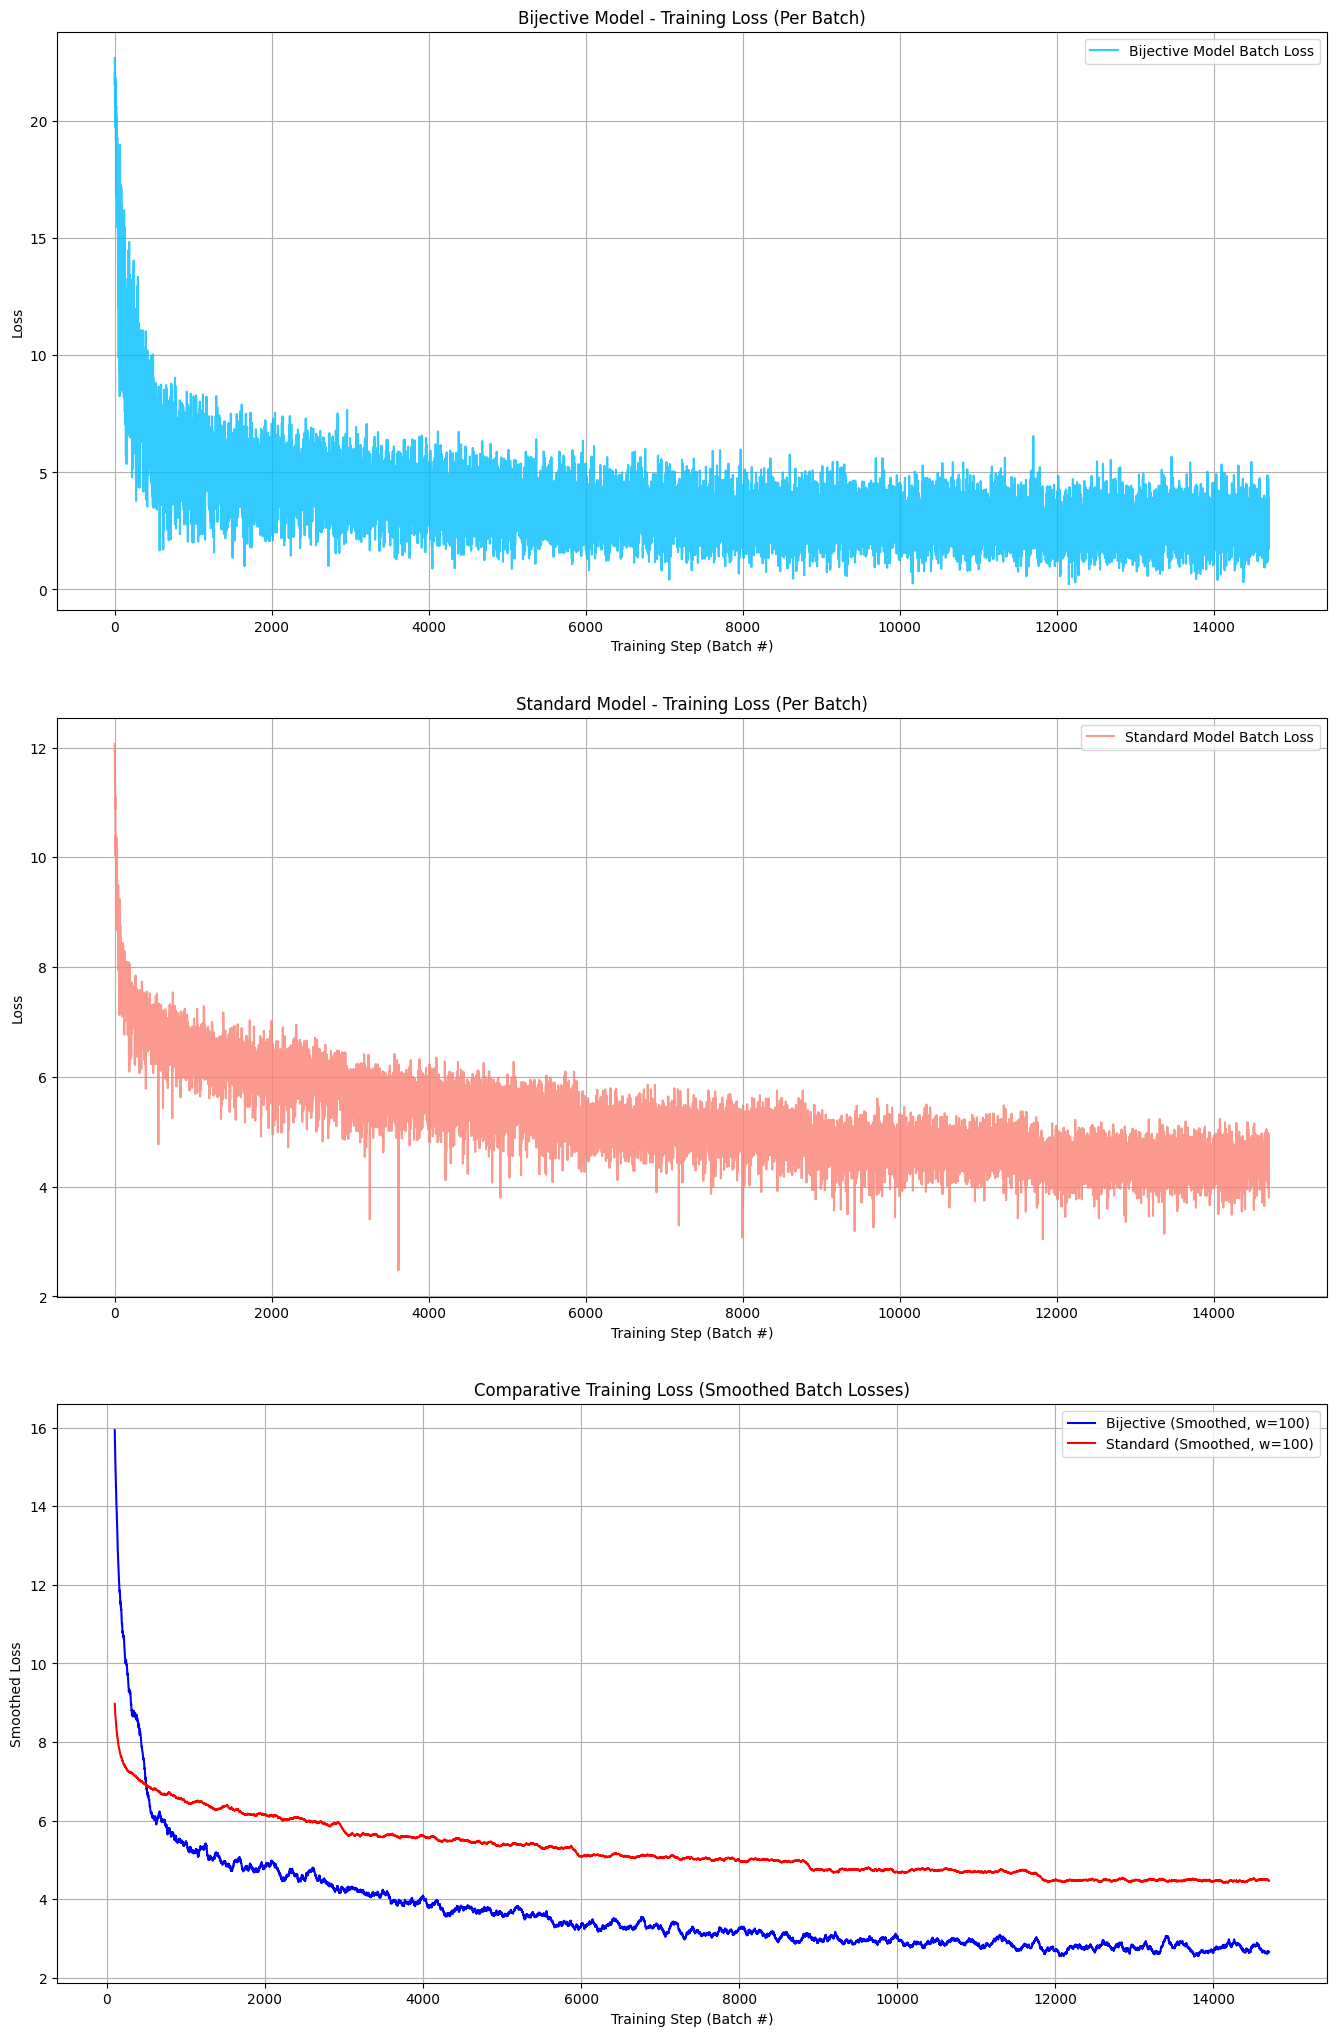

In [12]:
# 📊📈 CONSOLIDATED TRAINING LOSS PLOTS

import matplotlib.pyplot as plt
import numpy as np

# Ensure the following variables are accessible from previous cells:
# losses (list of batch losses from bijective model training)
# standard_model_losses (list of batch losses from standard model training)
# train_loader (the DataLoader instance, used to help determine smoothing window)

print("📊📈 Plotting Consolidated Training Losses...\n" + "="*40)

# Check if all required data is available
data_available = True
if 'losses' not in globals() or not losses:
    print("Warning: 'losses' data for Bijective Model not found or empty.")
    data_available = False
if 'standard_model_losses' not in globals() or not standard_model_losses:
    print("Warning: 'standard_model_losses' data for Standard Model not found or empty.")
    data_available = False
if 'train_loader' not in globals() or train_loader is None:
    print("Warning: 'train_loader' not found. Using a default smoothing window.")
    # data_available = False # Can still plot raw, but smoothing window needs a default

if not data_available and not ('losses' in globals() and standard_model_losses in globals()): # if neither is available
    print("Cannot generate plots: No loss data available.")
else:
    fig, axs = plt.subplots(3, 1, figsize=(14, 21)) # 3 rows, 1 column

    # --- Plot 1: Bijective Model - Batch Losses ---
    if 'losses' in globals() and losses:
        axs[0].plot(losses, label='Bijective Model Batch Loss', color='deepskyblue', alpha=0.8)
        axs[0].set_title('Bijective Model - Training Loss (Per Batch)')
        axs[0].set_xlabel('Training Step (Batch #)')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid(True)
    else:
        axs[0].text(0.5, 0.5, 'Bijective Model loss data not available.', ha='center', va='center')
        axs[0].set_title('Bijective Model - Training Loss (Per Batch)')


    # --- Plot 2: Standard Model - Batch Losses ---
    if 'standard_model_losses' in globals() and standard_model_losses:
        axs[1].plot(standard_model_losses, label='Standard Model Batch Loss', color='salmon', alpha=0.8)
        axs[1].set_title('Standard Model - Training Loss (Per Batch)')
        axs[1].set_xlabel('Training Step (Batch #)')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].grid(True)
    else:
        axs[1].text(0.5, 0.5, 'Standard Model loss data not available.', ha='center', va='center')
        axs[1].set_title('Standard Model - Training Loss (Per Batch)')

    # --- Plot 3: Comparative Plot - Smoothed Batch Losses ---
    axs[2].set_title('Comparative Training Loss (Smoothed Batch Losses)')
    axs[2].set_xlabel('Training Step (Batch #)')
    axs[2].set_ylabel('Smoothed Loss')
    plot_comparative_success = False

    if 'train_loader' in globals() and train_loader is not None:
        # Adaptive window size, e.g., 5% of an epoch's batches, min 10, max 100
        window_size = max(10, min(100, int(len(train_loader) * 0.05)))
    else:
        window_size = 50 # Default window if train_loader not found

    print(f"Using smoothing window size: {window_size} for comparative plot.")

    if 'losses' in globals() and losses and len(losses) > window_size:
        bijective_smoothed = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        # Adjust x-axis for 'valid' mode convolution: starts after window_size/2 batches effectively
        x_bijective = np.arange(window_size - 1, len(losses))
        axs[2].plot(x_bijective, bijective_smoothed, label=f'Bijective (Smoothed, w={window_size})', color='blue')
        plot_comparative_success = True
    elif 'losses' in globals() and losses: # Plot raw if not enough data to smooth
        axs[2].plot(losses, label='Bijective (Raw Batch Loss)', color='blue', alpha=0.5)
        print("Note: Plotting raw batch loss for Bijective Model as data is too short for smoothing.")
        plot_comparative_success = True


    if 'standard_model_losses' in globals() and standard_model_losses and len(standard_model_losses) > window_size:
        standard_smoothed = np.convolve(standard_model_losses, np.ones(window_size)/window_size, mode='valid')
        x_standard = np.arange(window_size - 1, len(standard_model_losses))
        axs[2].plot(x_standard, standard_smoothed, label=f'Standard (Smoothed, w={window_size})', color='red')
        plot_comparative_success = True
    elif 'standard_model_losses' in globals() and standard_model_losses: # Plot raw if not enough data to smooth
        axs[2].plot(standard_model_losses, label='Standard (Raw Batch Loss)', color='red', alpha=0.5)
        print("Note: Plotting raw batch loss for Standard Model as data is too short for smoothing.")
        plot_comparative_success = True

    if plot_comparative_success:
        axs[2].legend()
        axs[2].grid(True)
    else:
        axs[2].text(0.5, 0.5, 'Loss data for comparative plot not sufficient.', ha='center', va='center')

    plt.tight_layout(pad=3.0) # Add padding between subplots
    plt.show()

print("\n" + "="*40)
